In [1]:
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
cifar_path="../../Datasets/cifar10"
weight_path="../../Weights/Alexnet"

### Load Dataset

In [2]:
train_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])


train=torchvision.datasets.CIFAR10(root=cifar_path, train=True, download=True, transform=train_transform)
test=torchvision.datasets.CIFAR10(root=cifar_path, train=False, download=True, transform=test_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../Datasets/cifar10/cifar-10-python.tar.gz to ../../Datasets/cifar10
Files already downloaded and verified


In [8]:
train[0][1]

6

### Train, Validation split

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

indices=list(range(len(train)))
values=[y for _,y in train]

s=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in s.split(indices, values):
    print(f"#train:{len(train_idx)}")
    print(f"#val:{len(val_idx)}")


c:\Users\wongyun\miniconda3\envs\torchstudy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#train:40000
#val:10000


In [ ]:
import collections
from torch.utils.data import Subset

val=Subset(train, val_idx)
train=Subset(train, train_idx)

val_count=collections.Counter([y for _, y in val])
train_count=collections.Counter([y for _, y in train])

print(f"train distribution:{train_count}")
print(f"validation distribution:{val_count}")

train distribution:Counter({6: 4000, 7: 4000, 8: 4000, 3: 4000, 2: 4000, 1: 4000, 4: 4000, 9: 4000, 0: 4000, 5: 4000})
validation distribution:Counter({2: 1000, 7: 1000, 1: 1000, 9: 1000, 6: 1000, 8: 1000, 0: 1000, 3: 1000, 5: 1000, 4: 1000})


### Transform to DataLoader

In [ ]:
from torch.utils.data import DataLoader

batch_size=64
train_dl=DataLoader(train, batch_size=batch_size)
val_dl=DataLoader(val, batch_size=batch_size)

### Define Model

In [ ]:
#구현 안한거: Weight decay: validation set이 더이상 감소하지 않을 때 마다 weight 1/10 으로 줄이는거
#learning rate by 10 when the validation error rate stopped improving with the current learning rate.
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding='valid'),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2), #feature map size 27
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2), #feature map size 13
        )
        
        self.conv3=nn.Sequential(
            nn.Conv2d(256,384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )
        
        self.conv4=nn.Sequential(
            nn.Conv2d(384,384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )
        
        self.conv5=nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2), #feature map size 16
        )
        
        self.classifier=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(6*6*256, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096,num_class)
        )
        
        nn.init.normal_(self.conv1[0].weight, mean=0, std=0.01) #그냥 한번에 묶을걸,, 함수 만들어도 예외가 많아서 힘들듯
        nn.init.normal_(self.conv2[0].weight, mean=0, std=0.01)
        nn.init.normal_(self.conv3[0].weight, mean=0, std=0.01)
        nn.init.normal_(self.conv4[0].weight, mean=0, std=0.01)
        nn.init.normal_(self.conv5[0].weight, mean=0, std=0.01)  
        nn.init.normal_(self.classifier[1].weight, mean=0, std=0.01) 
        nn.init.normal_(self.classifier[4].weight, mean=0, std=0.01) 
        nn.init.normal_(self.classifier[6].weight, mean=0, std=0.01) 
        
        
        nn.init.constant_(self.conv1[0].bias, 0)
        nn.init.constant_(self.conv2[0].bias, 1)   
        nn.init.constant_(self.conv3[0].bias, 0)  
        nn.init.constant_(self.conv4[0].bias, 1)  
        nn.init.constant_(self.conv5[0].bias, 1)  
        nn.init.constant_(self.classifier[1].bias, 1) 
        nn.init.constant_(self.classifier[4].bias, 1) 
        nn.init.constant_(self.classifier[6].bias, 1) 
        
    def forward(self, x):
        output=self.conv1(x)
        output=self.conv2(output)
        output=self.conv3(output)
        output=self.conv4(output)
        output=self.conv5(output)
        
        output=output.view(-1, 6*6*256)
        
        output=self.classifier(output)
        
        return output

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AlexNet().to(device)

from torchsummary import summary
print(summary(model, input_size=(3,227,227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

### Define Optimizer and Loss function

In [ ]:
optimizer=torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9,)
loss_fn=nn.CrossEntropyLoss()

### Train and Validate

In [ ]:
import os

epoch=100

train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
best_acc=0
best_loss=float('inf')

acc_model_path=os.path.join(weight_path, 'alexnet_acc_fixed.pt')
loss_model_path=os.path.join(weight_path, 'alexnet_loss_fixed.pt')

for iter in range(epoch):
    running_loss=0
    running_acc=0    
    
    model.train()
    for i, data in enumerate(train_dl):
        
        train_x, train_y= data
        train_x, train_y= train_x.to(device), train_y.to(device)
        optimizer.zero_grad()
        train_pred=model(train_x)
        loss=loss_fn(train_pred, train_y)
        
        _, predicted = torch.max(train_pred, 1)
        acc = (predicted == train_y).squeeze().int()
        acc = torch.sum(acc)
        
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        running_acc+=acc
    
    print(f"epoch {iter+1}/{epoch} train loss: {running_loss/i} train acc: {running_acc/len(train)*100}%")
    train_loss.append(running_loss/i)
    train_accuracy.append(running_acc/len(train))
    
    running_loss=0
    running_acc=0
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_dl):
            
            val_x, val_y= data
            val_x, val_y= val_x.to(device), val_y.to(device)

            val_pred=model(val_x)
            loss=loss_fn(val_pred, val_y)

            _, predicted = torch.max(val_pred, 1)
            acc = (predicted == val_y).squeeze().int()
            acc = torch.sum(acc)

            running_loss+=loss.item()
            running_acc+=acc
    
    print(f"epoch {iter+1}/{epoch}, val loss: {running_loss/i} val acc: {running_acc/len(val)*100}%")
    val_loss.append(running_loss/i)
    val_accuracy.append(running_acc/len(val))
    
    if (running_acc/len(val)) >= best_acc: #validation accuracy가 가장 큰 모델로 저장
        print("Best model acc😊")
        best_model_acc=model
        
        best_acc=running_acc/len(val)
    
    if (running_loss/i)<best_loss:
        print("Best model loss😍")
        best_model_loss=model
        
        best_loss=(running_loss/i)
        
    print("==============================================================")
    torch.save(best_model_acc.state_dict(), acc_model_path)
    torch.save(best_model_loss.state_dict(), loss_model_path)
    #계속 저장하지말고 파일 만들고 마지막에 저장하기

epoch 1/100 train loss: 2.44435790907114 train acc: 10.094999313354492%
epoch 1/100, val loss: 2.3245903238272057 val acc: 9.999999046325684%
Best model acc😊
Best model loss😍
epoch 2/100 train loss: 2.3283642484591556 train acc: 10.264999389648438%
epoch 2/100, val loss: 2.3176896465130343 val acc: 9.999999046325684%
Best model acc😊
Best model loss😍
epoch 3/100 train loss: 2.317130284431653 train acc: 9.899999618530273%
epoch 3/100, val loss: 2.317857178357931 val acc: 9.999999046325684%
Best model acc😊
epoch 4/100 train loss: 2.313628064898344 train acc: 9.97249984741211%
epoch 4/100, val loss: 2.3174455074163585 val acc: 9.999999046325684%
Best model acc😊
Best model loss😍
epoch 5/100 train loss: 2.311133760290268 train acc: 10.017499923706055%
epoch 5/100, val loss: 2.317443982148782 val acc: 9.999999046325684%
Best model acc😊
Best model loss😍
epoch 6/100 train loss: 2.3104489548848224 train acc: 9.924999237060547%
epoch 6/100, val loss: 2.317441633114448 val acc: 9.999999046325684%


: 

: 

### Analysis

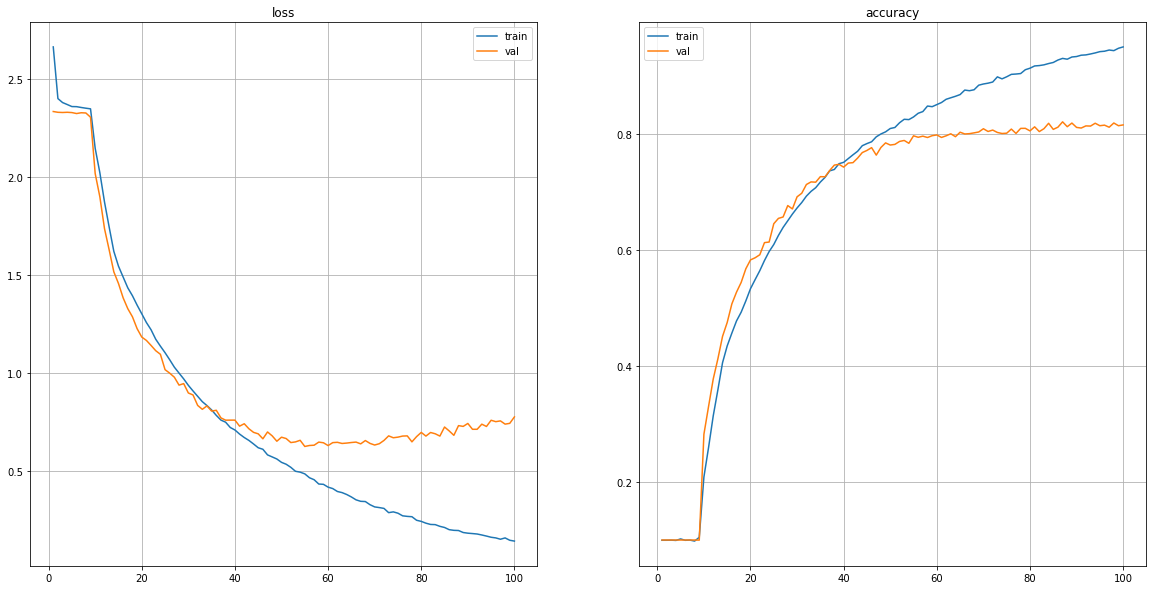

In [ ]:
import matplotlib.pyplot as plt

train_acc=[x.item() for x in train_accuracy]
val_acc=[x.item() for x in val_accuracy]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(np.arange(1,epoch+1), train_loss, label="train")
plt.plot(np.arange(1,epoch+1), val_loss, label="val")
plt.title("loss")
plt.grid(True)
plt.legend()

plt.subplot(122)
plt.plot(np.arange(1,epoch+1), train_acc, label="train")
plt.plot(np.arange(1,epoch+1), val_acc, label="val")
plt.title("accuracy")
plt.grid(True)
plt.legend()
plt.show()

### Test with test set

In [ ]:
model_best_acc=AlexNet().to(device) 
model_state_dict=torch.load(acc_model_path, map_location=device)
model_best_acc.load_state_dict(model_state_dict)

model_best_loss=AlexNet().to(device)
model_state_dict=torch.load(loss_model_path, map_location=device)
model_best_loss.load_state_dict(model_state_dict)

test_dl=DataLoader(test, batch_size=64)

##### Best loss model

In [ ]:
running_loss=0
running_acc=0

model_best_loss.eval()
with torch.no_grad():
    for i, data in enumerate(test_dl): 
        test_x, test_y= data
        test_x, test_y= test_x.to(device), test_y.to(device)
        
        test_pred=model_best_loss(test_x)
        loss=loss_fn(test_pred, test_y)
        _, predicted = torch.max(test_pred, 1)
        acc = (predicted == test_y).squeeze().int()
        acc = torch.sum(acc)
        
        running_loss+=loss.item()
        running_acc+=acc
        
    print(f"test loss: {running_loss/i}, test accuracy: {running_acc/len(test)*100}%")

test loss: 0.6328981759456488, test accuracy: 78.78999328613281%


#### Best accuracy model

In [ ]:
running_loss=0
running_acc=0

model_best_acc.eval()
with torch.no_grad():
    for i, data in enumerate(test_dl): 
        test_x, test_y= data
        test_x, test_y= test_x.to(device), test_y.to(device)
        
        test_pred=model_best_acc(test_x)
        loss=loss_fn(test_pred, test_y)
        _, predicted = torch.max(test_pred, 1)
        acc = (predicted == test_y).squeeze().int()
        acc = torch.sum(acc)
        
        running_loss+=loss.item()
        running_acc+=acc
        
    print(f"test loss: {running_loss/i}, test accuracy: {running_acc/len(test)*100}%")

test loss: 0.6979015754201473, test accuracy: 81.07999420166016%


결국 목적은 accuracy 아닌가? Accuracy 는 계속 증가하는데